# Image Caption Generator
Image caption generator is a model which generates caption based on the features presenet in the input image.

## Introduction
The basic working of project is that the features are axtracted from the images using pre-trained Xception model and then fed to the LSTM model along with the captions to train. The trained model is then capable of generating captions for any images that are fed into it.

## Dataset
The dataset used here is the [Flickr_8k_dataset](https://www.kaggle.com/adityajn105/flickr8k) which consist of 8091 images along with 5 captions for each images.

## Dependencies
* Keras - 2.3.1
* Tensorflow - 2.1.0
* Pre-trained Xception weights
* NLTK - 3.5
* Matplotlib - 3.3.1

## Steps to follow:

### Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import random
import os, time
import numpy as np
import pandas as pd
from collections import Counter
import pickle as pk
from PIL import Image

import keras
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Importing the image dataset and its respective captions

In [2]:
dir_flickr_img = 'flickr_8k_dataset/images'
dir_flickr_captions = 'flickr_8k_dataset/captions.txt'

imgs = os.listdir(dir_flickr_img)
print('The number of jpg files in Flickr_8k: {}'.format(len(imgs)))

The number of jpg files in Flickr_8k: 8091


In [3]:
#Finding captions for each image.
file = open(dir_flickr_captions, 'r', encoding='utf8')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split(',')
    if len(col) == 1:
        continue
    w = col[0].split('#')
    datatxt.append(w + [col[1].lower()])
    
df_txt = pd.DataFrame(datatxt, columns=['filename', 'caption'])

uni_filenames = np.unique(df_txt.filename.values)
print('The number of unique files : {}'.format(len(uni_filenames)))
print('The distribution of number of captions for each image: ')
Counter(Counter(df_txt.filename.values).values())
df_txt[:5]

The number of unique files : 8091
The distribution of number of captions for each image: 


,filename,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


### Plotting few images and their captions from the dataset

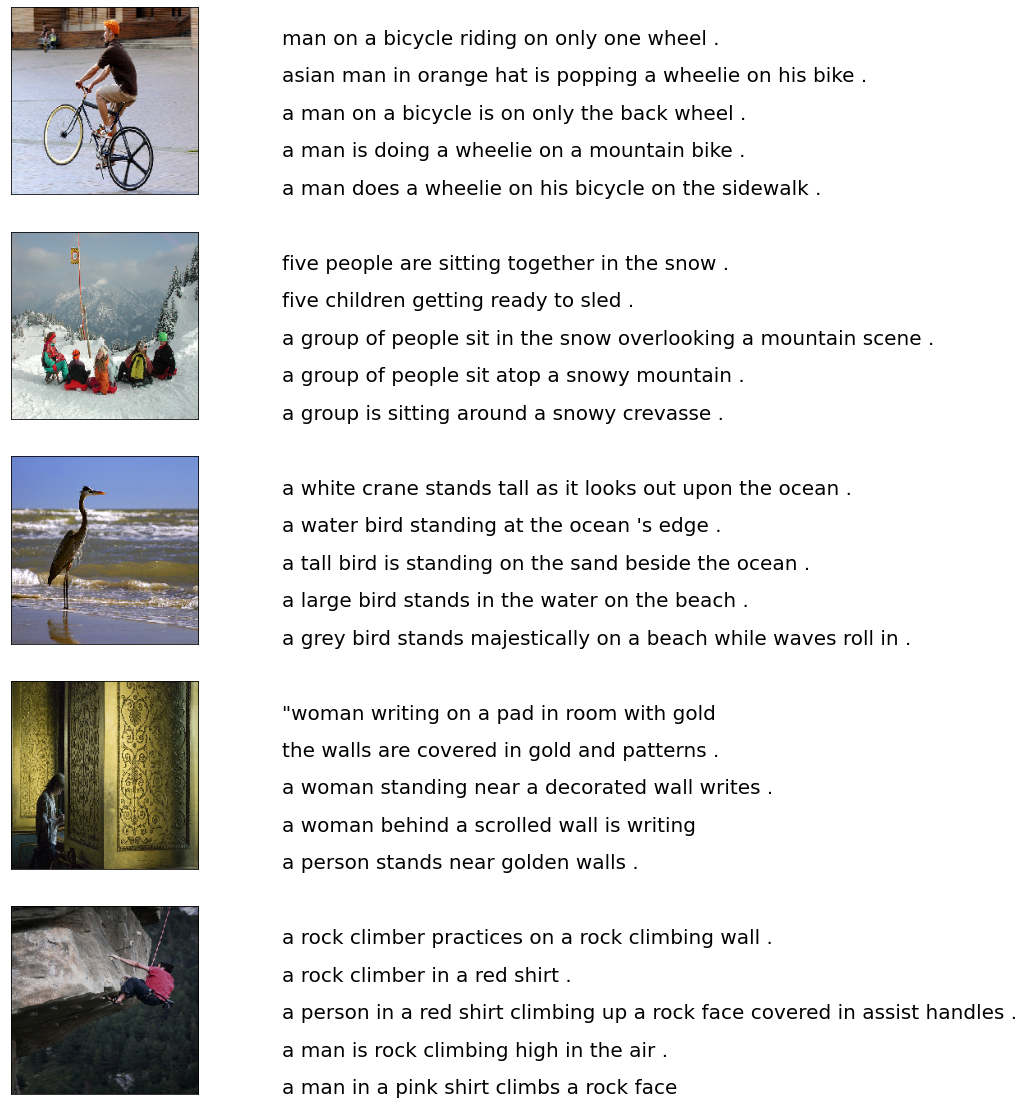

In [4]:
from IPython.display import display

npic = 5 #Displaying 5 images from the dataset
npix = 229
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10, 20))
for fnm in uni_filenames[-5:]:
    filename = dir_flickr_img + '/' + fnm
    captions = list(df_txt['caption'].loc[df_txt['filename']==fnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

### Cleaning captions for further analysis
The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it is fed to the model because uncleaned dataset will not create good captions for the images.

In [5]:
#Defining a function to calculate the top 3 words in all the captions availabel
def df_word(df_txt):
    vocab = []
    for txt in df_txt.caption.values:
        vocab.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocab)))
    ct = Counter(vocab)
    dfword = pd.DataFrame({'word': list(ct.keys()), 'count': list(ct.values())})
    dfword = dfword.sort_values('count', ascending=False)
    dfword = dfword.reset_index()[['word', 'count']]
    return dfword
dfword = df_word(df_txt)
dfword.head(10)

Vocabulary Size: 8871


,word,count
0,a,60196
1,.,34205
2,in,18174
3,the,17507
4,on,10357
5,is,9069
6,and,8057
7,dog,7948
8,with,7304
9,man,7137


In [6]:
import string
def text_clean(text):
    #removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #removing single character
    words = [word for word in text.split() if (len(word) > 1)]
    
    #removing numeric values
    words = [word for word in words if (word.isalpha())]
    
    text = ' '.join(words)
    return text

In [7]:
for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt['caption'].iloc[i] = newcaption

In [8]:
df_txt.head()

,filename,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin


### Plotting top 50 and least 50 words appeared in the cleaned dataset

Vocabulary Size: 8571


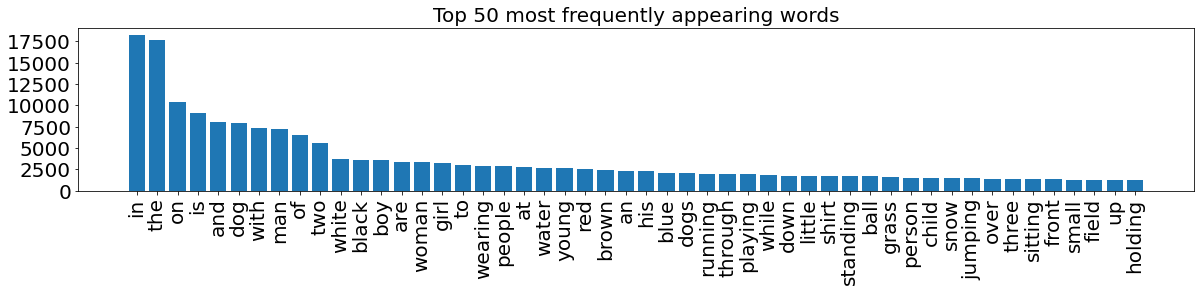

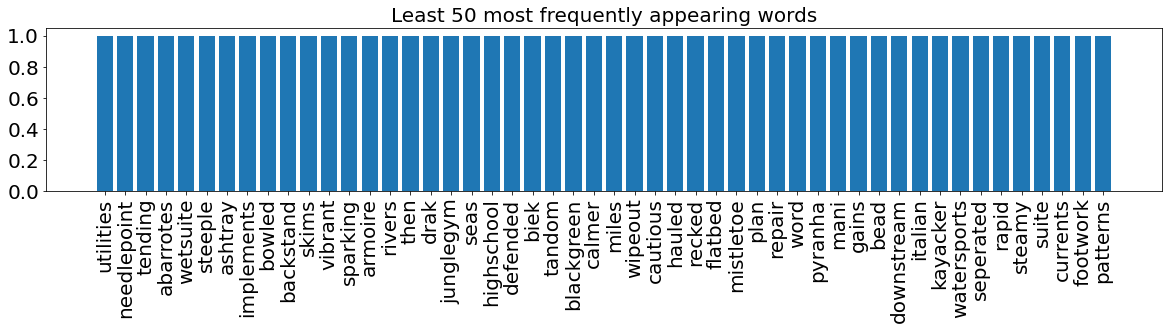

In [9]:
topn = 50
def plthist(dfsub, title="Top 50 most frequently appearning words"):
    plt.figure(figsize=(20, 3))
    plt.bar(dfsub.index, dfsub['count'])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index, dfsub['word'], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()
    
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title='Top 50 most frequently appearing words')
plthist(dfword.iloc[-topn:,:],
        title='Least 50 most frequently appearing words')

### Creating dictionary for all captions with image file names

In [10]:
def img_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    captions = text.split('\n')
    caption_dict ={}
    for caption in captions[:-1]:
        img, caption = caption.split(',')[:2]
        if img not in caption_dict:
            caption_dict[img] = [ caption ]
        else:
            caption_dict[img].append(caption)
    return caption_dict

In [11]:
caption_dict = img_captions(dir_flickr_captions)

In [12]:
for img, caps in caption_dict.items():
    for i, img_caption in enumerate(caps):
        img_caption = text_clean(img_caption)
        caption_dict[img][i] = img_caption

### Store cleaned dictionary into a text file

In [13]:
def save_dict(caption_dict, filename):
    lines = list()
    for img_name, caps in caption_dict.items():
        for cap in caps:
            lines.append(img_name + '\t' + cap)
    data = "\n".join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
save_dict(caption_dict, 'descriptions.txt')    

### Loading Xception model and Extracting the feature vector from all images

In [15]:
from keras.applications.xception import Xception, preprocess_input
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + '/' + img
        image = Image.open(filename)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        image = image / 127.5
        image = image - 1.0
        
        feature = model.predict(image)
        features[img] = feature
    return features

features = extract_features(dir_flickr_img)

pk.dump(features, open('features.p', 'wb'))

C:\Users\Bhavesh kumar\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Loading dataset for Training the model
Also append the start and end identifier for each caption

In [16]:
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_imgs(filename):
    file = load_file(filename)
    images = file.split("\n")[:-1]
    return images

def load_clean_descriptions(filename, images):
    file = load_file(filename)
    descriptions = {}
    for line in file.split('\n'):
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        
        if image in images:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(images):
    all_features = pk.load(open('features.p', 'rb'))
    features = {k : all_features[k] for k in images}
    return features

filename = "flickr_8k_dataset/Flickr_8k.trainImages.txt"
train_imgs = load_imgs(filename)
train_descriptions = load_clean_descriptions('descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

In [17]:
{k: train_descriptions[k] for k in list(train_descriptions)[:2]}

{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> Two dogs of different breeds looking at each other on the road <end>',
  '<start> Two dogs on pavement moving toward each other <end>']}

### Tokenizing the vocabulary

In [18]:
all_desc = []
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
        
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)

pk.dump(tokenizer, open('tokenizer.p', 'wb'))

In [19]:
token_size = len(tokenizer.word_index) + 1
token_size

7402

In [20]:
#Calculate max length of descriptions
max_length = max(len(d.split()) for d in all_desc)
max_length

30

### Create Data Generator
To make this task into a supervised learning task, we have to provide input and output to the model for training. We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represent as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield input and output sequence.

In [21]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, desc_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, desc_list, feature)
            yield [[input_image, input_sequence], output_word]
            
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    #Walk through each descriptions for the image
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            #split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=token_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

[a, b], c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
print(a.shape, b.shape, c.shape)

(47, 2048) (47, 30) (47, 7402)


### Defining the CNN-RNN Model

In [38]:
def nn_model(tokenizer_size, max_length):
    #features squezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    #LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(tokenizer_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    #Adding both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(tokenizer_size, activation='softmax')(decoder2)
    
    #Add [img, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    
    return model

### Training the model

In [39]:
print('Dataset : ', len(train_imgs))
print('Descriptions: train = ', len(train_descriptions))
print('images: train = ', len(train_features))
print('Vocabulary Size : ', tokenizer_size)
print('Description Max length : ', max_length)


model = nn_model(tokenizer_size, max_length)
epochs = 10
steps = len(train_descriptions)
os.mkdir('models')
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset :  6000
Descriptions: train =  6000
images: train =  6000
Vocabulary Size :  7402
Description Max length :  30
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 256)      1894912     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_3

C:\Users\Bhavesh kumar\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 2685s 447ms/step - loss: 4.4740
Epoch 1/1
6000/6000 [==============================] - 2355s 392ms/step - loss: 3.6166
Epoch 1/1
6000/6000 [==============================] - 2120s 353ms/step - loss: 3.3323
Epoch 1/1
6000/6000 [==============================] - 2111s 352ms/step - loss: 3.1617
Epoch 1/1
6000/6000 [==============================] - 2110s 352ms/step - loss: 3.0444
Epoch 1/1
6000/6000 [==============================] - 2116s 353ms/step - loss: 2.9557
Epoch 1/1
6000/6000 [==============================] - 2149s 358ms/step - loss: 2.8919
Epoch 1/1
6000/6000 [==============================] - 2158s 360ms/step - loss: 2.8355
Epoch 1/1
6000/6000 [==============================] - 2143s 357ms/step - loss: 2.7909
Epoch 1/1
6000/6000 [==============================] - 2131s 355ms/step - loss: 2.7569


In [24]:
model = load_model('models/model_9.h5')
epochs = 13
steps = len(train_descriptions)
for i in range(10, epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Epoch 1/1
6000/6000 [==============================] - 2612s 435ms/step - loss: 2.7268
Epoch 1/1
6000/6000 [==============================] - 2259s 376ms/step - loss: 2.6947
Epoch 1/1
6000/6000 [==============================] - 2141s 357ms/step - loss: 2.6769


In [25]:
df_txt.head()

,filename,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin


### Creating dataframe where only first caption is taken and Indexing of all images

In [26]:
l = []
count = 0
for i in df_txt.index:
    if i % 5 == 0:
        count = 0
    l.append(count)
    count += 1

df_txt['index'] = l
    
features = pk.load(open('features.p', 'rb'))
df_txt = df_txt.loc[df_txt['index'].values == 0, :]
dimages, keepindex = [], []
for i, fnm in enumerate(df_txt['filename']):
    if fnm in features.keys():
        dimages.append(features[fnm])
        keepindex.append(i)
        
dcaptions = df_txt['caption'].iloc[keepindex].values
fname = df_txt['filename'].iloc[keepindex].values        
dimages = np.array(dimages)

### We trained model for 6000 images so 2000 images for testing

In [27]:
di_test = dimages[6000:]
fnm_test = fname[6000:]
dcaptions = dcaptions[6000:]

In [28]:
len(di_test)

2091

### Generating captions on a small set of images
After the model finishes training we can test out its performance on the some of the test images to figure out if the generated captions are good enough. If the generated captions are good enough we can generate the captions for the whole test dataset

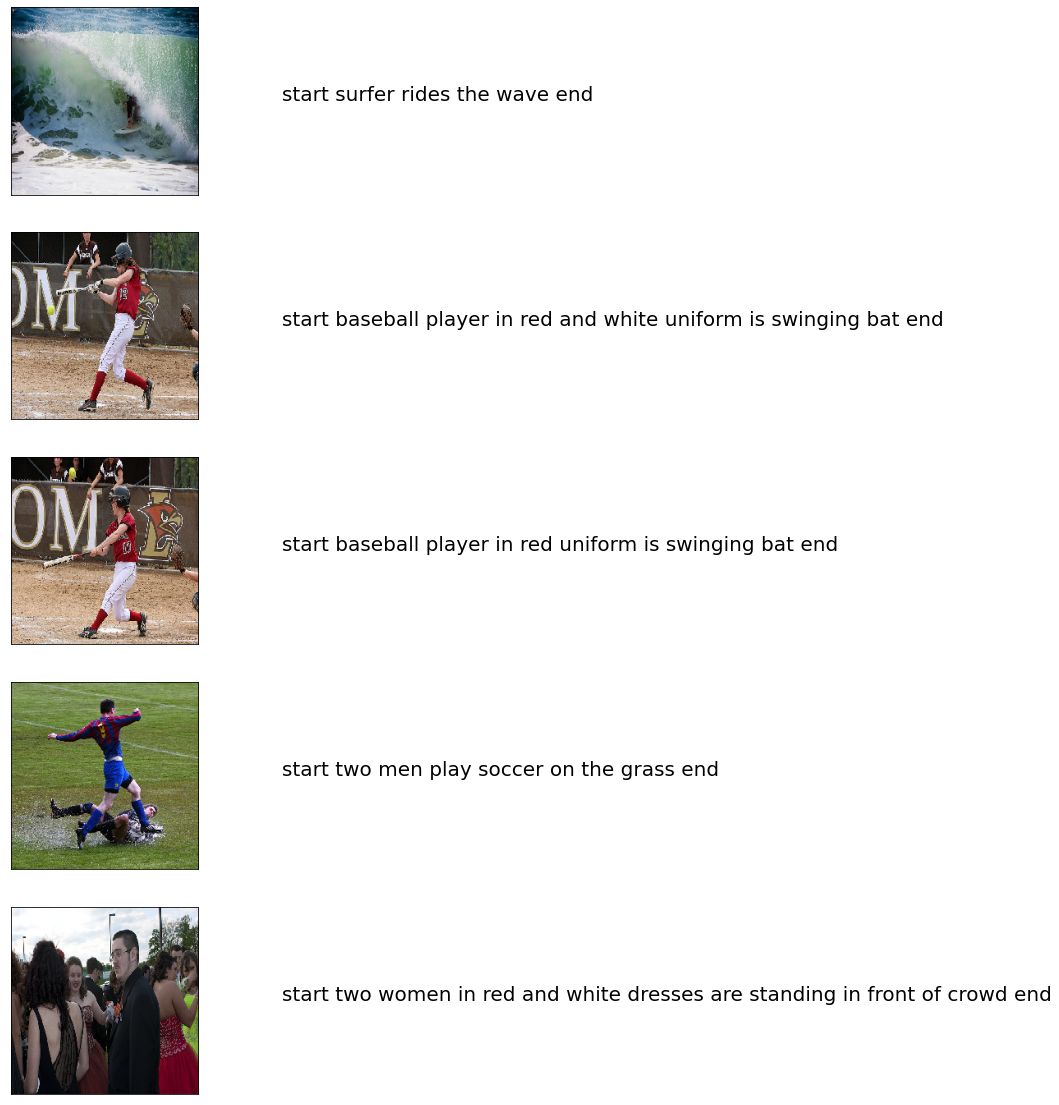

In [40]:
tokenizer = pk.load(open("tokenizer.p", "rb"))
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])
model = load_model('models/model_12.h5')
max_length = 30

def predict_caption(image):
    in_text = 'start'
    for iword in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([image, sequence], verbose=0)
        pred = np.argmax(pred)
        new_word = index_word[pred]
        in_text += " " + new_word
        if new_word == 'end':
            break
    return in_text

npic = 5
npix = 229
target_size = (npix, npix, 3)

count = 1

fig = plt.figure(figsize=(10, 20))
for img_fnm, image_feature in zip(fnm_test[25:30], di_test[25:30]):
    #images
    filename = dir_flickr_img + '/' + img_fnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    #captions
    caption = predict_caption(image_feature)
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0.5, caption, fontsize=20)
    count += 1
    
plt.show()

## Evaluating the model performance
After the model is trained we have to test the models prediction capabilities on test dataset. Traditional accuracy metric can't be used on predictions. For text evaluations we have a metric called as [BLEU Score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). BLEU stands for Bilingual Evaluation Understudy, it is a score for comparing a candidate text to one or more reference text.

Example:

In [31]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference = "I do like dog"
references = [reference.split()]

In [32]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
chencherry = SmoothingFunction()
print("Bleu Score = {:4.3f}".format(sentence_bleu(references, hypothesis, smoothing_function=chencherry.method2)))

Bleu Score = 0.458


In [33]:
hypothesis2 = "I love dog!".split()
print("Bleu Score = {:4.3f}".format(sentence_bleu(references, hypothesis2, smoothing_function=chencherry.method2)))

Bleu Score = 0.324


###  Generating captions for the whole test data and finding BLEU Score

In [34]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])
dt_test = tokenizer.texts_to_sequences(dcaptions)

nkeep = 5
pred_good, pred_bad, bleu_scores = [], [], []
count = 0
for img_fnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format((100 * count / float(len(fnm_test)))))
        
    caption_true = [ index_word[i] for i in tokenized_text ]
    caption_true = caption_true
    
    caption = predict_caption(image_feature)
    caption = caption.split()
    caption = caption[1:-1]
    
    bleu = sentence_bleu([caption_true], caption, smoothing_function=chencherry.method2)
    bleu_scores.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu, img_fnm, caption_true, caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu, img_fnm, caption_true, caption))

  9.56% is done..
  19.13% is done..
  28.69% is done..
  38.26% is done..
  47.82% is done..
  57.39% is done..
  66.95% is done..
  76.52% is done..
  86.08% is done..
  95.65% is done..


In [35]:
print("Mean Bleu Score : {:4.3f}".format(np.mean(bleu_scores)))

Mean Bleu Score : 0.131


### Good and bad captions examples from the model
We can check out some of the generated caption's quality. Some times due to complex nature of the images the generated captions are not good.

Good Caption


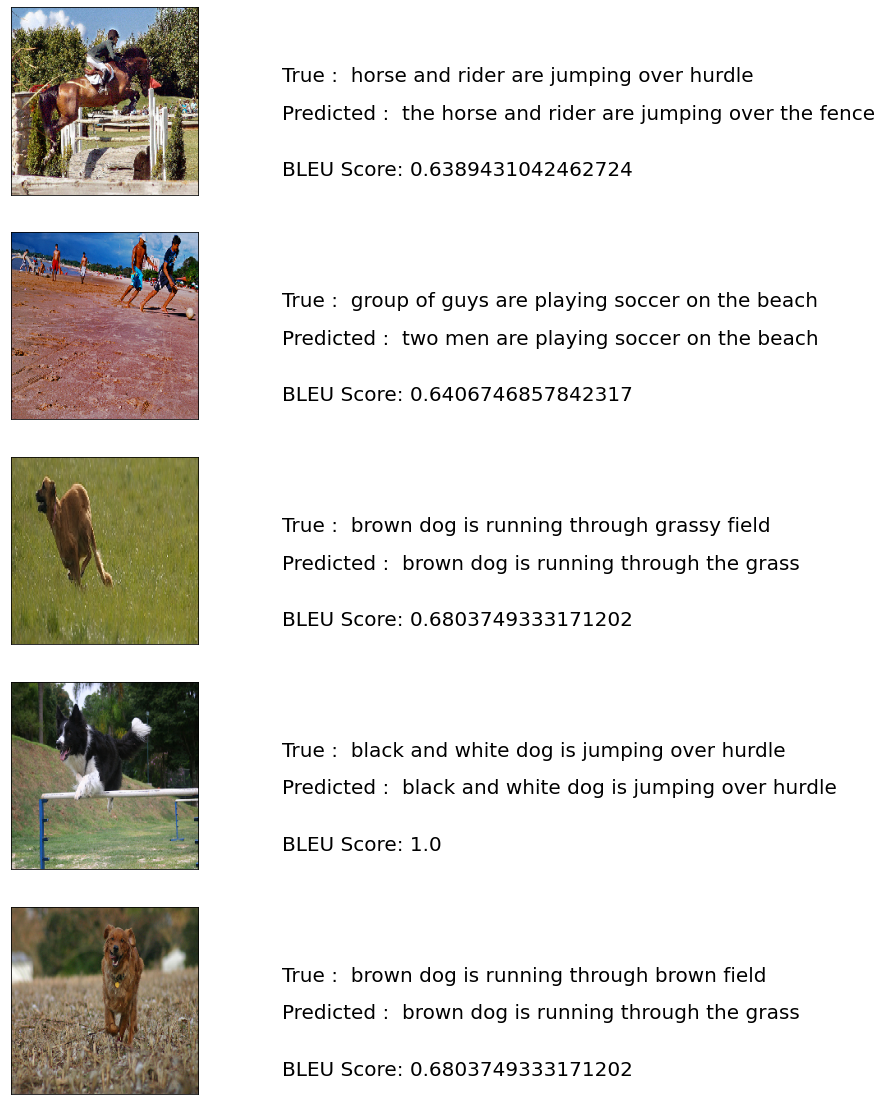

Bad Caption


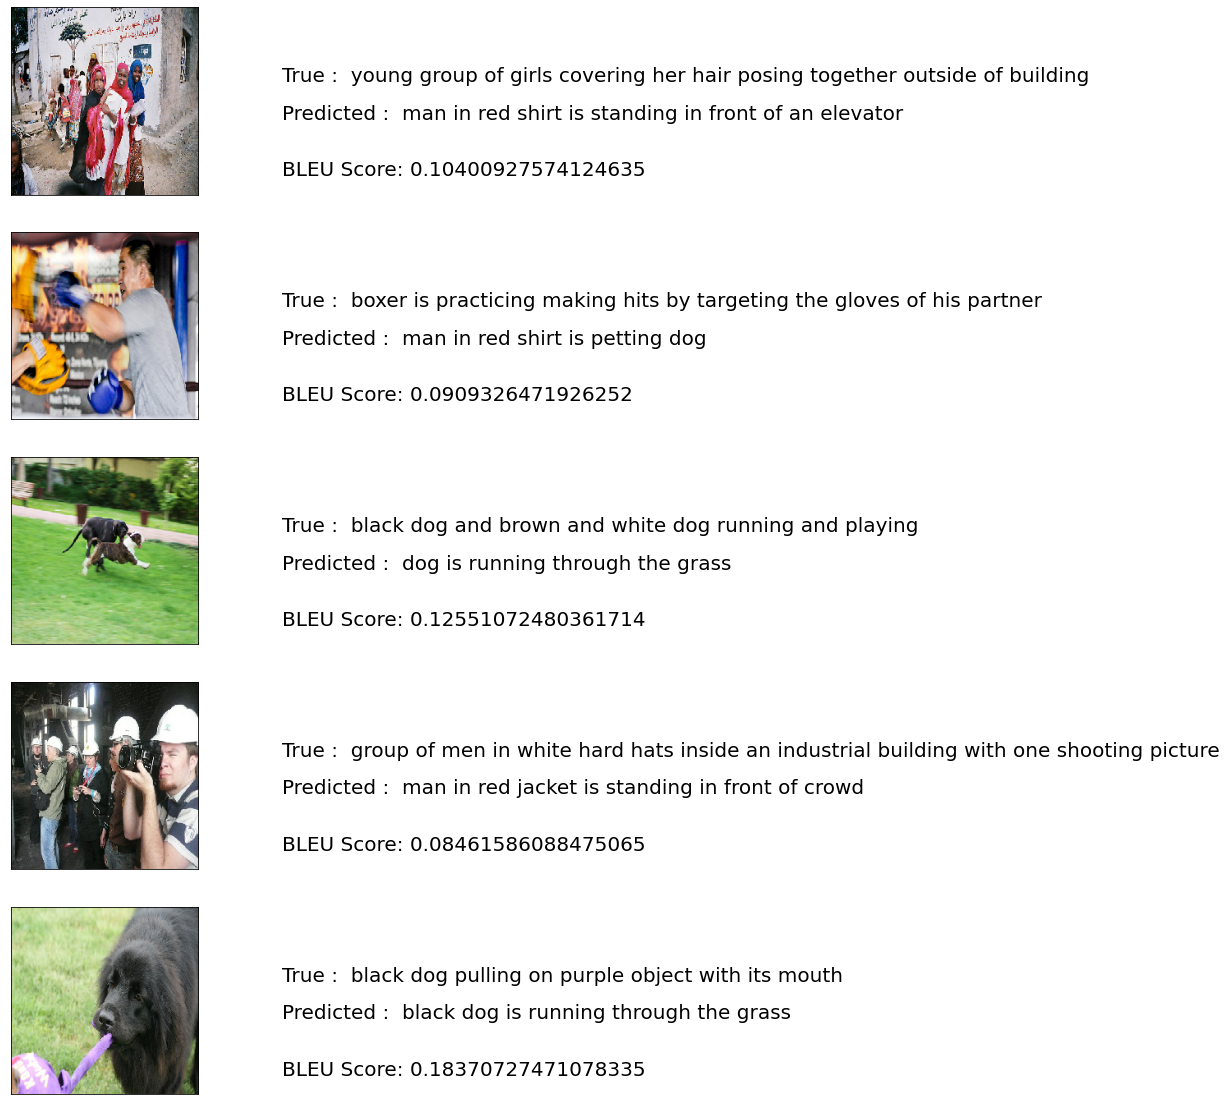

In [36]:
def plot_images(prediction):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return strue
    npix = 229
    target_size = (npix, npix, 3)
    count = 1
    fig = plt.figure(figsize=(10, 20))
    npic = len(prediction)
    for pred in prediction:
        bleu, img_fnm, caption_true, caption = pred
        filename = dir_flickr_img + '/' + img_fnm
        load_image = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(load_image)
        count += 1
        
        caption_true = create_str(caption_true)
        caption_pred = create_str(caption)
        
        ax = fig.add_subplot(npic, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.text(0, 0.6, "True : " + caption_true, fontsize=20)
        ax.text(0, 0.4, "Predicted : " + caption_pred, fontsize=20)
        ax.text(0, 0.1, "BLEU Score: {}".format(bleu), fontsize=20)
        count += 1
    plt.show()

print("Good Caption")
plot_images(pred_good)
print('Bad Caption')
plot_images(pred_bad)        
               

## Conclusion
The model has been successfully trained to generate the captions as expected for the images. The caption generation has constantly been improved by fine tunining the model with different hyper parameter. Higher BLEU score indicates that the generated captions are very similar to those of the actual caption present on the images.

Some key points to note that
* This model depends on data, so it cannot predict the words that are out of its vocabulary. I used small dataset consisting of 8000 images.
* Higher BLEU score doesn't always translate to better generated captions. If the model overfits on training data, it will lead the model to go through details in the image and generate out captions which don't make sense. It can be seen in the good and bad captions genereated above. 